# Project
## Determining the better tariff for a telecom company 

Tasks:
- perform an analysis of the customers' behavior on a given sample;
- figure out which tariff brings more revenue per user.

Available data contains information on 500 users.

-----

## Executive Summary
    
1. *Ultra* tariff plan users use various services more than *Smart* tariff plan users.
2. *Ultra* users bring 65% more monthly revenue per person on average than *Smart* users.
3. No difference was found between the average monthly revenue per user by region (Moscow vs. other localities).
    
**Recommendation:** focus on promoting the *Ultra* tariff.

## Table of contents

[Description of Tariff Plans](#paragraph0)

1. [General Information](#paragraph1)
2. [Data Preprocessing](#paragraph2)
    1. [Adjusting Data Types, Correcting Mistakes and Working with Missing Values and Duplicates ](#subparagraph1)
    2. [Feature Engineering](#subparagraph4)  
    
3. [Customer Behavior Analysis](#paragraph3)
4. [Revenue Analysis](#paragraph4)
    1. [Hypothesis about the difference in revenues between the users of different plans](#subparagraph5)
    2. [Hypothesis about the difference in revenue per user between Moscow and other localities](#subparagraph6) 
5. [Summary](#paragraph5)

<center> <h3>Description of Tariff Plans</h3> </center> <a name="paragraph0"></a>

| Tariff Plan | "Smart" | "Ultra" |
|---|---|---|
|Monthly fee | 550 rubles | 1950 rubles|
| *Services in the tariff plan* |||
| calls | 500 min  | 3000 min  |
| messaging |  50 pc | 1000 pc |
| internet |  15 GB | 30 GB |
| *Fees for services in the tariff plan* |||
| for 1 min  | 3 rubles  | 1 ruble  |
| for 1 message (sms)  |  3 rubles | 1 ruble  |
| for 1 GB of traffic  |  200 rubles | 150 rubles |

*Minutes and megabytes are rounded up. If the user spoke for only 1 second, the whole minute is counted in the tariff plan.*

<center> <h3>1. General Information</h3> </center> <a name="paragraph1"></a>

Для анализа предоставлены 5 датасетов, каждый из которых содержит отдельную часть информации:
- о звонках
- об использовании интернета
- о сообщениях
- о тарифах
- о пользователях

Получим общую информацию по каждому из датасетов.

For analysis, 5 datasets are provided. Each of them contains a separate piece of information:
- about calls
- about using the internet
- about messages
- about tariffs
- about users

Let's get general information on each of the datasets.

In [2]:
import pandas as pd
import numpy as np
import datetime as dt

import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats as st 
import scipy

In [3]:
# ignoring warnings
import warnings
warnings.filterwarnings("ignore")

# centering outputs
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [4]:
datasets = {'users':'datasets/users.csv', 
            'calls':'datasets/calls.csv', 
            'internet':'datasets/internet.csv', 
            'messages':'datasets/messages.csv', 
            'tariffs':'datasets/tariffs.csv'} 

for dataset in datasets.keys():
    print(dataset)
    print(pd.read_csv(datasets[dataset]).info())
    print()

users
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB
None

calls
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB
None

int

---
#### Intermediary Summary

At first glance, there are no obvious problems with the data. 
- No missing values (in NaN format). And where they are present (like in the `churn_date` variable), it seems to be justified.
- There is a variable `Unnamed: 0` in the dataset about internet usage. It's not very clear what it means. It looks like a bug (or a duplicated index), but we'll check more thoroughly in the next step.
---

<center> <h3>2. Data Preprocessing</h3> </center> <a name="paragraph2"></a>

#### 2.1. Adjusting Data Types, Correcting Mistakes and Working with Missing Values and Duplicates <a name="subparagraph1"></a>

**About approach.** We will perform data preprocessing on each dataset separately (instead of creating one megadataset), because it seems to be more effective due to the potential specificity of each dataset, as well as from the point of view of memory usage and writing code.

*2.1.1. Users*

In [5]:
users = pd.read_csv('datasets/users.csv')
users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


In [6]:
# checking for duplicates
print('Number of duplicates:', users.duplicated().sum())

Number of duplicates: 0


In [7]:
# checking for hidden duplicates. 
# For example, people who moved from one city to another or changed tariff plans
print('Number of duplicates:', users[['first_name', 'last_name']].duplicated().sum())

Number of duplicates: 0


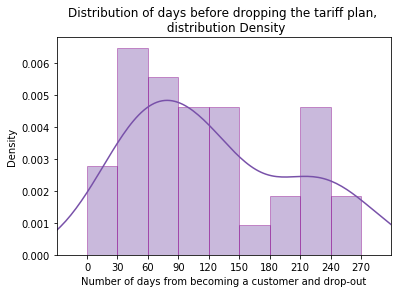

In [8]:
# Let's see if the churn variable poses a problem
# For example, the customers who haven't used the plan for a month can distort the picture

users["reg_date"] = pd.to_datetime(users["reg_date"], format='%Y-%m-%d')
users["churn_date"] = pd.to_datetime(users["churn_date"], format='%Y-%m-%d')
# (users["churn_date"] - users["reg_date"]).dt.days.dropna().hist(bins='auto', density=False);
churn_users = (users["churn_date"] - users["reg_date"]).dt.days.dropna()
ax = sns.distplot(a=churn_users, bins=[0, 30, 60, 90, 120, 150, 180, 210, 240, 270], color='#7851a9', hist_kws=dict(edgecolor="darkmagenta"))
ax.set(xlim=(-30, 300), title='Distribution of days before dropping the tariff plan, \n distribution Density');
ax.set(xlabel='Number of days from becoming a customer and drop-out');
ax.set(xticks=range(0, 300, 30));

In [9]:
print("Share of customers who dropped in the first 30 days:", ((churn_users < 30).sum() / len(churn_users)).round(2))

Share of customers who dropped in the first 30 days: 0.08


In [10]:
# checking for oddities in city names, fares, and ages
cols = ['age', 'city', 'tariff']

for col in cols:
    print('Unique Values', col, '-', users[col].nunique())
    print(sorted(users[col].unique()))
    print()

Unique Values age - 58
[18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75]

Unique Values city - 76
['Архангельск', 'Астрахань', 'Балашиха', 'Барнаул', 'Белгород', 'Брянск', 'Владивосток', 'Владикавказ', 'Владимир', 'Волгоград', 'Волжский', 'Вологда', 'Воронеж', 'Грозный', 'Екатеринбург', 'Иваново', 'Ижевск', 'Иркутск', 'Казань', 'Калининград', 'Калуга', 'Кемерово', 'Киров', 'Кострома', 'Краснодар', 'Красноярск', 'Курган', 'Курск', 'Липецк', 'Магнитогорск', 'Махачкала', 'Москва', 'Мурманск', 'Набережные Челны', 'Нижневартовск', 'Нижний Новгород', 'Нижний Тагил', 'Новокузнецк', 'Новороссийск', 'Новосибирск', 'Омск', 'Оренбург', 'Орёл', 'Пенза', 'Пермь', 'Петрозаводск', 'Подольск', 'Ростов-на-Дону', 'Рязань', 'Самара', 'Санкт-Петербург', 'Саранск', 'Саратов', 'Севастополь', 'Смоленск', 'Сочи', 'Ставрополь', 'С

No errors, typos or strange namings were identified.

*2.1.2. Calls*

In [11]:
calls = pd.read_csv('datasets/calls.csv')
calls.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


In [12]:
# checking for duplicates
print('Number of duplicates:', calls.duplicated().sum())

Number of duplicates: 0


In [13]:
# At the beginning of the dataset zero values can be found. These are, probably, missed calls. 
# Let's see how many of these values we have got in the dataset
print('Number of missed calls among all calls', (calls['duration'] == 0.00).sum())
print('Share of missed calls among all calls {:.2%}'.format(((calls['duration'] == 0.00).sum() / len(calls))))

Number of missed calls among all calls 39613
Share of missed calls among all calls 19.55%


---
#### Intermediary Summary

There are quite a lot of values - about 20% of all calls.

The answer to the question of whether to include them into the analysis depends on the purpose of the analysis. Since the final goal of the analysis is revenue, and missed calls (0 min. 0 sec.) do not represent the subject of pricing, one can safely remove these values.

*Comment*: Moreover, for the calculation of average call duration this information would only shift the estimate downwards being completely irrelevant, as the calls themselves would then not take place. Analysis of missed calls may be an interesting task in itself, but again, it does not seem relevant for this analysis.

---

In [14]:
# removing missed calls
calls = calls[calls['duration'] != 0.00]

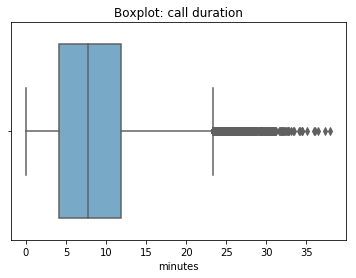

In [15]:
# checking for outliers 
ax = sns.boxplot(x=calls['duration'], palette="Blues")
ax.set(title='Boxplot: call duration', xlabel='minutes');

In [16]:
# let's calculate the upper bound above which the values will be claasified as outliers
# (one and a half interquartile ranges from the 3rd quartile)
outlier_cutpoint = calls['duration'].quantile(0.75) + 1.5 * scipy.stats.iqr(calls[calls['duration'] != 0.00]['duration'].dropna())

In [17]:
# calculating share of outliers among all observations
outlier_share = calls[calls['duration'] >= outlier_cutpoint]['id'].count() / len(calls)
print('Share of outliers: {:.1%}'.format(outlier_share))

Share of outliers: 0.8%


---
#### Intermediary Summary

It seems feasible to remove the outliers, since there are only few of them. But due to the fact that we are dealing with two asymmetric tariff plans, it is better not to do this as users of each tariff plan have different conditions and users of the more expensive plan may, for example, be more prone to long calls (maybe that's why they pay for this tariff plan).

---

*2.1.3. Messages*

In [18]:
messages = pd.read_csv('datasets/messages.csv')
messages.head()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


In [19]:
# checking for duplicates
print('Number of duplicates:', calls.duplicated().sum())

Number of duplicates: 0


*2.1.4. Internet Traffic*

In [20]:
internet = pd.read_csv('datasets/internet.csv')
internet.head()

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


In [21]:
# variable "Unnamed: 0" looks like a duplicate of the index. Let's get rid of it
internet = internet[['id', 'mb_used', 'session_date', 'user_id']]

In [22]:
# checking for duplicates
print('Number of duplicates:', calls.duplicated().sum())

Number of duplicates: 0


In [23]:
# There might be zero values in the dataset.
# Let's see how many of these values are in the dataset
print('Number of sessions with zero traffic:', (internet['mb_used'] == 0.00).sum())
print('Share of sessions with zero traffic: {:.2%}'.format(((internet['mb_used'] == 0.00).sum() / len(internet))))

Number of sessions with zero traffic: 19598
Share of sessions with zero traffic: 13.12%


Quite a few sessions with zero traffic. Let's do the same with this data as we did with the missed calls, e.i. get rid of them.

In [24]:
internet = internet[internet['mb_used'] != 0.00]

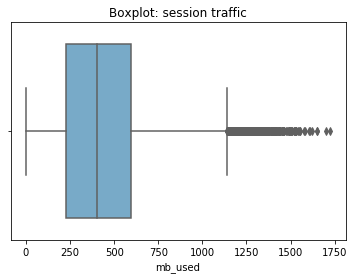

In [25]:
# checking for outliers 
ax = sns.boxplot(x=internet['mb_used'], palette="Blues")
ax.set(title='Boxplot: session traffic');

In [26]:
# let's calculate the upper bound above which the values will be claasified as outliers
# (one and a half interquartile ranges from the 3rd quartile)
outlier_cutpoint = internet[internet['mb_used'] != 0.00]['mb_used'].quantile(0.75) + 1.5 * scipy.stats.iqr(internet[internet['mb_used'] != 0.00]['mb_used'].dropna())

In [27]:
# Calculating share of outliers among all observations
outlier_share = internet[internet['mb_used'] != 0.00][internet['mb_used'] >= outlier_cutpoint]['id'].count() / len(internet[internet['mb_used'] != 0.00])
print('Share of outliers: {:.1%}'.format(outlier_share))

Share of outliers: 0.7%


We will proceed in the same way as with atypically long calls - we will leave them because of the asymmetricity of tariffs.

*2.1.5. Tariff Plans*

In [28]:
tariffs = pd.read_csv('datasets/tariffs.csv')
tariffs = tariffs.set_index('tariff_name')
tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
tariff_name,,,,,,,
smart,50,15360,500,550,200,3,3
ultra,1000,30720,3000,1950,150,1,1


In [29]:
# converting the price per gb to price per mb
tariffs['rub_per_mb'] = (tariffs['rub_per_gb'] / 1024).round(2)

tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,rub_per_mb
tariff_name,,,,,,,,
smart,50,15360,500,550,200,3,3,0.20
ultra,1000,30720,3000,1950,150,1,1,0.15


#### 2.2. Feature Engineering <a name="subparagraph4"></a>

We will calculate the following statistics for each user:

1. Number of calls made and minutes spent in each month;
- Number of messages sent in each month;
- Amount of Internet traffic consumed in each month;
- Monthly revenue per user.

The data will be collected in the megadataset `users_stats`. For convenience and in accordance with the principles of personal data protection, only the depersonalized `user_id` will be used as a user identifier.

**Preparatory Stage I.** To accurately calculate revenue, the first three variables (calls, messages, and internet) are not enough, as these metrics do not cover all sources of revenue. Monthly Plan Fee stays uncovered. There might probably be months when, for whatever reason, the customer did not use any services or the Internet. If that's the case, we could miss these months in the analysis. To prevent this, let's add active months for each user to the dataset `users_stats` (starting from when the client signed up and ending at the end of the year or when the client terminated the contract).

In [30]:
users_data = users[['user_id', 'city', 'tariff', 'reg_date', 'churn_date']]

# adding month of registration
users_data['reg_month'] = pd.to_datetime(users_data['reg_date'], format='%Y-%m-%d').dt.month

# adding month of drop-out (if present)
users_data['churn_month'] = pd.to_datetime(users_data['churn_date'], format='%Y-%m-%d').dt.month

In [31]:
# adding active month column to each user
all_months = pd.DataFrame([x for x in range(1, 13)]).rename(columns={0:'month'})
all_months['key'] = '1'
users_data['key'] = '1'
users_data = all_months.merge(users_data, on='key')

# getting rid of months before registration date
users_data = users_data[(users_data['month'] >= users_data['reg_month'])]

# getting rid of months after drop-out date
users_data['churn_month'] = users_data['churn_month'].fillna(13)
users_data = users_data[(users_data['month'] <= users_data['churn_month'])]
users_data['churn_month'] = users_data['churn_month'].where(users_data['churn_month'] != 13, np.nan)

In [32]:
users_data[users_data['user_id'] == 1328]

,month,key,user_id,city,tariff,reg_date,churn_date,reg_month,churn_month
4828,10,1,1328,Мурманск,ultra,2018-10-16,NaT,10,NaN
5328,11,1,1328,Мурманск,ultra,2018-10-16,NaT,10,NaN
5828,12,1,1328,Мурманск,ultra,2018-10-16,NaT,10,NaN


**Preparatory Stage II.** Since we are interested in monthly data, we can immediately and centrally extract the performance months for each observation from the available timestamps/datetime data in each dataset:

In [33]:
datasets = [calls, messages, internet]
for dataset in datasets:
    cols = dataset.columns
    for col in cols:
        if 'date' in col:
            dataset['month'] = pd.to_datetime(dataset[col], format='%Y-%m-%d').dt.month
            
# checking results
calls.head()

,id,call_date,duration,user_id,month
2,1000_2,2018-06-11,2.85,1000,6
3,1000_3,2018-09-21,13.80,1000,9
4,1000_4,2018-12-15,5.18,1000,12
7,1000_7,2018-08-22,18.31,1000,8
8,1000_8,2018-09-15,18.44,1000,9


---------------------------------
**Feature Extraction**

Extracting number of calls per user-month

In [34]:
# Number of calls (without missed calls) 
calls_number = calls.pivot_table(index=['user_id', 'month'], values=['id'], aggfunc='count')
calls_number = calls_number.rename(columns={'id':'total_calls'})

Extracting number of minutes per user-month

In [35]:
# number of minutes spent by month
# first, we convert the duration of the calls into minutes, which is the basis for the revenue calculation 
# this means we, first, round them up and then add them for up the user in a given month
calls['total_minutes'] = calls['duration'].apply(np.ceil)
calls_duration = calls.pivot_table(index=['user_id', 'month'], values=['total_minutes'], aggfunc='sum').reset_index()

Merging data on calls and minutes

In [36]:
calls_data = calls_number.merge(calls_duration, on=['user_id', 'month'], how='outer')

Extracting number of messaged per user-month

In [37]:
# number of messages sent by month
messages_data = messages.pivot_table(index=['user_id', 'month'], values=['id'], aggfunc='count').reset_index()
messages_data = messages_data.rename(columns={'id':'total_messages'})

Extracting amount of internet traffic per user-month

In [38]:
# the amount of Internet traffic consumed in a given month
# First, we round up the MB of each session
# Then we add up the amounts of each sessions for the user-month 


internet['total_mb'] = internet['mb_used'].apply(np.ceil)
internet_data = internet.pivot_table(index=['user_id', 'month'], values=['total_mb'], aggfunc='sum').reset_index()

Merging all extracted data

In [39]:
# monthly revenue per user
# making several data merges
revenue_data = users_data.merge(calls_data, on=['user_id', 'month'], how='left')
revenue_data = revenue_data.merge(messages_data, on=['user_id', 'month'], how='left')
revenue_data = revenue_data.merge(internet_data, on=['user_id', 'month'], how='left')

revenue_data.head(3)

,month,key,user_id,city,tariff,reg_date,churn_date,reg_month,churn_month,total_calls,total_minutes,total_messages,total_mb
0,1,1,1005,Набережные Челны,smart,2018-01-25,NaT,1,NaN,11.0,95.0,7.0,2730.0
1,1,1,1032,Ульяновск,smart,2018-01-04,NaT,1,NaN,44.0,380.0,38.0,24147.0
2,1,1,1045,Улан-Удэ,smart,2018-01-30,NaT,1,NaN,1.0,9.0,5.0,2348.0


Some preprocessing

In [40]:
# keeping only relevant parameters 
revenue_data = revenue_data[['user_id', 'tariff', 'city', 'month', 'total_minutes', 'total_messages', 'total_mb']]

# adjusting data types (not necessary but beautiful)
for col in revenue_data.columns:
    if revenue_data[col].dtype == 'float64':
        revenue_data[col] = revenue_data[col].astype('Int64')
        
revenue_data.head(3)

,user_id,tariff,city,month,total_minutes,total_messages,total_mb
0,1005,smart,Набережные Челны,1,95,7,2730
1,1032,smart,Ульяновск,1,380,38,24147
2,1045,smart,Улан-Удэ,1,9,5,2348


In [41]:
# checking for missing values
revenue_data.isna().sum()

user_id             0
tariff              0
city                0
month               0
total_minutes      48
total_messages    499
total_mb           15
dtype: int64

In [42]:
# Apparently, there are clients who did not make any calls in some months, 
# did not text or use the internet
# let's fill these values with zeros
revenue_data = revenue_data.fillna(0)

**Calculating revenue per user per month**

Writing a funtion which calculates monthly revenue per user

In [43]:
# writing a function that will calculate monthly revenue per user
def revenue_calculator(row):
    # плата по тарифу
    monthly = tariffs.loc[row['tariff'], 'rub_monthly_fee']
    
    # выручка за звонки
    call_revenue = max(0, row['total_minutes'] - tariffs.loc[row['tariff'], 'minutes_included']) * tariffs.loc[row['tariff'], 'rub_per_minute']
    
    # выручка за сообщения
    message_revenue = max(0, row['total_messages'] - tariffs.loc[row['tariff'], 'messages_included']) * tariffs.loc[row['tariff'], 'rub_per_message']
    
    # выручка за интернет
    internet_revenue = max(0, row['total_mb'] - tariffs.loc[row['tariff'], 'mb_per_month_included']) * tariffs.loc[row['tariff'], 'rub_per_mb']
    
    # суммируем
    total_revenue = monthly + call_revenue + message_revenue + internet_revenue
    return total_revenue

Applying function to the dataset

In [44]:
# calculating revenue
revenue_data['monthly_rev_per_cust'] = revenue_data.apply(revenue_calculator, axis=1)

In [45]:
revenue_data.head()

,user_id,tariff,city,month,total_minutes,total_messages,total_mb,monthly_rev_per_cust
0,1005,smart,Набережные Челны,1,95,7,2730,550.0
1,1032,smart,Ульяновск,1,380,38,24147,2307.4
2,1045,smart,Улан-Удэ,1,9,5,2348,550.0
3,1055,smart,Казань,1,551,30,17111,1053.2
4,1071,smart,Омск,1,194,16,15622,602.4


---
#### Intermediary Summary

**Description of steps and transformations performed:**
1. Based on available datasets, we calculated how much each customer used each of the services for each valid* month of 2018.
2. This data was then consolidated into one dataset.
3. A funtion was written to calculate monthly revenue for a given customer based on the above data.
3. Next, the monthly revenue for each client for each month was calculated. 


 *A valid month means a month when the customer has an unterminated contract. When calculating revenue, it is important not to accidentally include the months before signing the contract (=registration) and the months when the customer has already terminated it (=churn). 

---

<center> <h3>3. Customer Behavior Analysis</h3> </center> <a name="paragraph3"></a>

**Intro.** In this section, we will try to answer the following question: how many minutes, how many messages and how much Internet traffic is consumed by users of each tariff plan per month?

**Approach.** For this, we'll calculate (1) the mean, variance and standard deviation, and then (2) build histograms to understand the distribution of the above parameters.

#### 3.1. Descriptive Statistics

*Comment:* zero values will not be used in the calculation. Otherwise, we would underestimate statistics for those who use these services.

In [46]:
# Convert MB to GB for convenience and clarity
revenue_data['total_gb'] = revenue_data['total_mb'] / 1024

# Descriptive statistics for both tariff plans
parameters = ['total_minutes', 'total_messages', 'total_gb']

tariff_stats = []

for tariff in ['smart', 'ultra']:
    subset = revenue_data[revenue_data['tariff'] == tariff]
    for parameter in parameters:
        mean = np.mean(subset[parameter])
        variance = np.var(subset[parameter], ddof=1)
        stdev = np.std(subset[parameter], ddof=1)
        tariff_stats.append([parameter, tariff, mean, variance, stdev])
    
tariff_stats = pd.DataFrame(tariff_stats).round(2)
tariff_stats.columns = ['Component', 'Tariff Plan', 'Mean', 'Variance', 'St. Deviation']
tariff_stats = tariff_stats.sort_values('Component').set_index(['Component', 'Tariff Plan'])
tariff_stats.rename({'total_gb':'Internet Traffic, Gb', 'total_messages':'Messages', 'total_minutes':'Minutes'})

Mean   Variance  St. Deviation
Component            Tariff Plan                                  
Internet Traffic, Gb smart         15.84      33.04           5.75
                     ultra         19.01      97.48           9.87
Messages             smart         33.37     796.96          28.23
                     ultra         49.31    2285.42          47.81
Minutes              smart        417.75   36281.39         190.48
                     ultra        526.09  101052.49         317.89

#### 3.2. Distribution Visualizations

*Comment:* we will get rid of zero values when constructing graphs, as they strongly distort distributions.

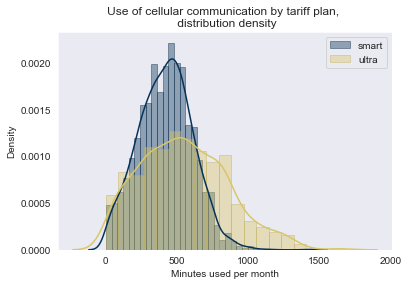

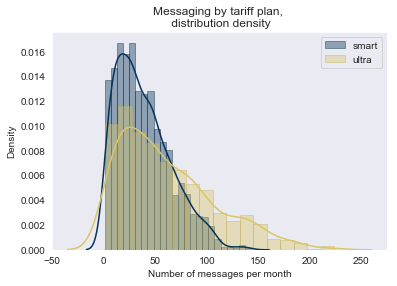

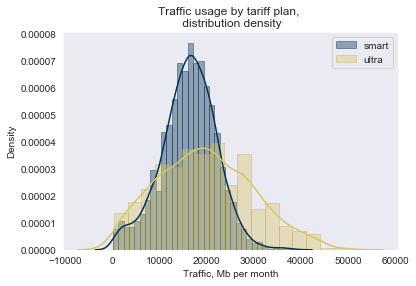

In [48]:
# Plotting distributions of basic metrics
# Let's prepare the names of the graphs
plot_specs = {'smart':{'color':'#053259', 'edgecolor':'#042440'}, 
              'ultra':{'color':'#D9C666', 'edgecolor':'#BFAE5A'}}

series = {'total_minutes':{'title':'Use of cellular communication by tariff plan, \n distribution density', 
                           'xlabel':'Minutes used per month',
                          'x':1250, 'y':0.16}, 
          'total_messages':{'title':'Messaging by tariff plan, \n distribution density', 
                            'xlabel':'Number of messages per month',
                           'x':150, 'y':0.25}, 
          'total_mb':{'title':'Traffic usage by tariff plan, \n distribution density', 
                      'xlabel':'Traffic, Mb per month', 
                     'x':35, 'y':0.09}}
# Histograms
for serie in series.keys():
    for tariff in plot_specs.keys():
        sns.set_style("dark")
        data = revenue_data[revenue_data['tariff'] == tariff]
        data = data[data[serie] != 0.00][serie]
        ax = sns.distplot(a=data, color=plot_specs[tariff]['color'], label=tariff,
                          hist_kws=dict(edgecolor=plot_specs[tariff]['edgecolor']))
        ax.set(title=series[serie]['title'], 
               xlabel=series[serie]['xlabel'])
        ax.legend()
    plt.show()
    print()

**Several observations:**
- The distributions for the tariff *ultra* are flatter (and, accordingly, the right *tail* is longer). It sounds feasible that a larger proportion of users of a more expensive tariff plan use more of the services.
- Distributions for Internet traffic and minutes are close to normal. The distribution of messages is more Poisson-like.

**Comparison of typical (average) users of *Smart* and *Ultra* tariff plans**
- Phone calls. *Ultra* tariff plan users spend about 110 (+25%) more minutes per month than *Smart* users.
- Messages. On average the number of messages sent each month by *Ultra* users is 16 (almost +50%) more than by *Smart* users.
- Internet. *Ultra* users spend 3Gb (+20%) more internet traffic per month than *Smart* users.

**Comparison of user groups for both tariff plans**.
- Among *Ultra* customers there are relatively more of those who consume the services more than the average (longer tail on the right side of the distributions). 
- At the same time we can say that the group of *Ultra* users in general is less homogeneous: the spread of values for all three services is more disperse for them. On the contrary, *Smart* users have more pronounced (higher) peaks of distributions. It is likely that there are many clients among *Ultra* users who care about the fact that they have large service packages as it gives them a feeling of greater freedom, although they will not necessarily use services more than *Smart* clients. This is partially possible to detect also - compared to *Smart*, there are also relatively many ultra-customers who consume services less than the group average. In other words, the left side of the distribution of *Ultra* customers is flatter than among *Smart* ones. 

<center> <h3>4. Revenue Analysis</h3> </center> <a name="paragraph4"></a>

#### 4.1. Hypothesis about the difference in revenues between the users of different plans <a name="subparagraph5"></a>

Let's first check visually if the variance of the revenue per customer in available samples on 2 tariff plans can be considered identical

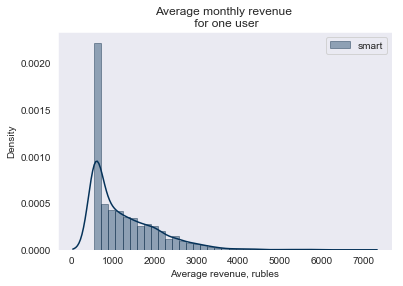

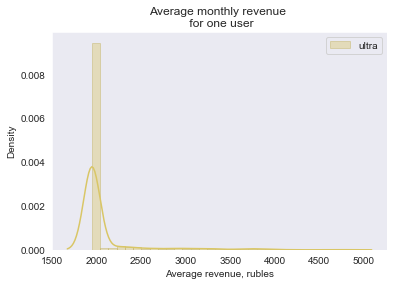

In [49]:
for tariff in plot_specs.keys():
    data = revenue_data[revenue_data['tariff'] == tariff]['monthly_rev_per_cust']
    ax = sns.distplot(a=data, color=plot_specs[tariff]['color'], label=tariff,
                        hist_kws=dict(edgecolor=plot_specs[tariff]['edgecolor']))
    ax.set(title='Average monthly revenue \n for one user', xlabel='Average revenue, rubles')
    sns.set_style("dark")
    ax.legend()
    plt.show()

Obviously, due to the two very different peaks we will see a meaningful difference. It seems that these two peaks correspond to users who only pay monthly fixed fee. Let's check it:

In [50]:
total = len(revenue_data[revenue_data['tariff'] == 'smart'])
part = len(revenue_data[revenue_data['tariff'] == 'smart'][revenue_data['monthly_rev_per_cust'] == 550])
print('Share of Smart users who only pay fixed monthly fee: {:.1%}'.format(part / total))

total = len(revenue_data[revenue_data['tariff'] == 'ultra'])
part = len(revenue_data[revenue_data['tariff'] == 'ultra'][revenue_data['monthly_rev_per_cust'] == 1950])
print('Share of Ultra users who only pay fixed monthly fee: {:.1%}'.format(part / total))

Share of Smart users who only pay fixed monthly fee: 25.3%
Share of Ultra users who only pay fixed monthly fee: 86.4%


In spite of the above evidence, we will also conduct a formal test to compare averages of the two samples:

- Student's test for samples with different variance (Null-Hypothesis of no difference between sample means)
- Nonparametric Mann-Whitney test for similarity of distributions (formally preferable to the Student's test, because the distributions above are not similar to normal) (Zero-Hypothesis of no difference between sample distributions)

In [51]:
sample_1 = revenue_data[revenue_data['tariff'] == 'smart']['monthly_rev_per_cust']
sample_2 = revenue_data[revenue_data['tariff'] == 'ultra']['monthly_rev_per_cust']

t_results = st.ttest_ind(sample_1, sample_2, equal_var = False) 
mw_results = st.mannwhitneyu(sample_1, sample_2)
print('p-value for T-test: ', t_results.pvalue)
print('p-value for Mann-Whitney: ', mw_results.pvalue)

p-value for T-test:  2.7264649365907094e-280
p-value for Mann-Whitney:  2.2998854151576345e-205


In [52]:
# calculating means of samples
print('Monthly average per user-month for Smart: {:.0f} rubles'.format(sample_1.mean()))
print('Monthly average per user-month for Ultra: {:.0f} rubles'.format(sample_2.mean()))

Monthly average per user-month for Smart: 1246 rubles
Monthly average per user-month for Ultra: 2063 rubles


**Intermediate conclusion.** At the 1% significance level, we cannot accept the null hypothesis of equality of the average monthly revenue between tariff plans. The tariff Ultra brings on average more revenue, and this observation is statistically significant.

#### 4.2. Hypothesis about the difference in revenue per user between Moscow and other localities <a name="subparagraph6"></a>

In [53]:
# grouping all users by Moscow vs other localities
revenue_moscow = revenue_data[revenue_data['city'] == 'Москва']['monthly_rev_per_cust']
revenue_other = revenue_data[revenue_data['city'] != 'Москва']['monthly_rev_per_cust']

# grouping Smart users by Moscow vs other localities
smart_data = revenue_data[revenue_data['tariff'] == 'smart'].reset_index(drop=True)
smart_revenue_moscow = smart_data[smart_data['city'] == 'Москва']['monthly_rev_per_cust']
smart_revenue_other = smart_data[smart_data['city'] != 'Москва']['monthly_rev_per_cust']

# grouping Ultra users by Moscow vs other localities
ultra_data = revenue_data[revenue_data['tariff'] == 'ultra'].reset_index(drop=True)
ultra_revenue_moscow = ultra_data[ultra_data['city'] == 'Москва']['monthly_rev_per_cust']
ultra_revenue_other = ultra_data[ultra_data['city'] != 'Москва']['monthly_rev_per_cust']

In [55]:
# let's calculate the statistics for the whole dataset
t_results = st.ttest_ind(revenue_moscow, revenue_other, equal_var = True) 
mw_results = st.mannwhitneyu(revenue_moscow, revenue_other)

both_stats = ['Both tariffs', revenue_moscow.mean(), revenue_other.mean(), t_results.pvalue, mw_results.pvalue]

# let's calculate the statistics for smart users
t_results_smart = st.ttest_ind(smart_revenue_moscow, smart_revenue_other, equal_var = True) 
mw_results_smart = st.mannwhitneyu(smart_revenue_moscow, smart_revenue_other)

smart_stats = ['smart', smart_revenue_moscow.mean(), smart_revenue_other.mean(), t_results_smart.pvalue, mw_results_smart.pvalue]

# let's calculate the statistics for ultra users 
t_results_ultra = st.ttest_ind(ultra_revenue_moscow, ultra_revenue_other, equal_var = True) 
mw_results_ultra = st.mannwhitneyu(ultra_revenue_moscow, ultra_revenue_other)

ultra_stats = ['ultra', ultra_revenue_moscow.mean(), ultra_revenue_other.mean(), t_results_ultra.pvalue, mw_results_ultra.pvalue]

stats = pd.DataFrame([both_stats, smart_stats, ultra_stats])
stats.columns = ['Tariff Plan', 'Average revenue in Moscow', 'Average revenue in other localities', 
                 'Student Test, p-value', 'Mann-Whitney Test, p-value']
stats.set_index('Tariff Plan').T.round(2)

Tariff Plan,Both tariffs,smart,ultra
Average revenue in Moscow,1515.90,1195.04,2066.35
Average revenue in other localities,1491.98,1256.70,2062.10
"Student Test, p-value",0.50,0.17,0.88
"Mann-Whitney Test, p-value",0.14,0.14,0.10


**The following null hypotheses were tested on two samples (Moscow vs. other localities):**
- equality of average revenue and identity of distributions
- equality of average revenue and identity of distributions for Smart tariff plan
- equality of average revenue and identity of distributions for Ultra tariff plan  

These null hypotheses cannot be rejected at the 5% (or even 10%) significance level.

<center> <h3>5. Summary</h3> </center> <a name="paragraph5"></a>

**Data Preprocessing**. A number of datasets describing service usage by 500 clients from 76 Russian cities for 2018 were provided for analysis. Based on the provided data on calls, messages and Internet traffic, the revenue from each client for each month was calculated.

**Analysis of Customer Behavior.** When analyzing customer behavior for the two tariffs, it was revealed that, based on sample analysis, Ultra tariff users tended to consume all three services more. However, no tests were conducted to establish the significance of this observation.

**Hypothesis Testing.** When analyzing the average monthly revenue per client:
- no statistically significant difference was found between the average monthly revenue in Moscow and other localities.
- a statistically significant difference was found between the user revenues in each of the Tariff plans.

**Recommendation.**
In terms of average monthly revenue, it is worth focusing on the promoting the Ultra tariff as it brings on average 65% more revenue per user.